In [1]:
library(repr)
library(tidyverse)
options(repr.plot.width=8, repr.plot.height=4)
library(xtable)
library(latex2exp)

Warning message:
“package ‘repr’ was built under R version 3.4.4”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
Warning message:
“package ‘tibble’ was built under R version 3.4.3”Warning message:
“package ‘tidyr’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”Warning message:
“package ‘dplyr’ was built under R version 3.4.4”Warning message:
“package ‘stringr’ was built under R version 3.4.4”Warning message:
“package ‘forcats’ was built under R version 3.4.3”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
Warning message:
“package ‘xtable’ was built under R version 3.4.4”

In [2]:
RejectByHolmBonf <- function(x, var.x, alpha=0.05){
    # Reject values in x via Holm-Bonferroni procedure
    # My own implementation.
    #
    # Args:
    #   x: vector of xbar values.
    #   var.x: variance associate with xbar values.
    #   alpha: type 1 error level
    #
    # Returns:
    #   values in x that were not rejected.
    N <- length(x)
    min.idx <- which.min(x)
    
    x.star <- x[min.idx]
    var.x.star <- var.x[min.idx]
    
    x.test <- x[-min.idx]
    var.x.test <- var.x[-min.idx]

    w <- (x.test - x.star)/sqrt(var.x.test + var.x.star)
    p <- 1.-pnorm(w)
    
    p.ordered <- sort(p)
    
    accept.test <- p.ordered > (alpha/(N - (1:(N-1))))
    
    if (sum(accept.test) == 0) {
        # Reject all
        accept.idxs <- c()
    } else if (sum(accept.test) == N-1) {
        # Accept all
        accept.idxs <- 1:(N-1)
    } else {
        k <- which(accept.test)[1]
        accept.p <- p.ordered[k:(N-1)]
        accept.idxs <- match(accept.p, p)
    }
    return(c(x.star, x.test[accept.idxs]))
}


TestRejectByHolmBonf <- function() {
    N <- 100
    n <- 10
    num.runs <- 1000
    fp <- 0
    for (i in 1:num.runs) {
        x <- matrix(c(rep(1, n), rexp((N-1)*n, 1)), nrow=N, ncol=n, byrow = T)
        xbar <- apply(x, 1, mean)
        var.xbar <- apply(x, 1, var)/n
        xbar.notrejected <- RejectByHolmBonf(xbar[xbar>=1], var.xbar[xbar>=1], alpha=0.05)
        if (length(xbar.notrejected) < sum(xbar>=1)) {
            fp <- fp + 1
        }
    }
    print("TestRejectByHolmBonf")
    print(fp/num.runs > 0.03 && fp/num.runs < 0.06)
}

TestRejectByHolmBonf()


CalcPocockErrorAndSampleSize <- function (n, alpha){
    # Calculate the alpha dash values and sample size for interim analyses
    #
    # Args:
    #   n: vector of sample size at each analysis.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   A list containing alpha dash and the sample size at each analysis.
    if (length(n) > 1){
        if (length(n) == 3) {
            alpha.dash <- rep(0.02317456, 3)
        } else if (length(n) == 5) {
            alpha.dash <- rep(0.01693147, 5)
        } else {
            information.fraction <- n/max(n)
            spent.error <- alpha * log(1+(exp(1)-1)*information.fraction)
            alpha.dash <- c(spent.error[1], diff(spent.error))
        }
        n.delta <- c(n[1], diff(n))
    } else {
        alpha.dash <- alpha
        n.delta <- n
    }
    return(list(alpha.dash=alpha.dash, n.delta=n.delta))
}

TestCalcPocockErrorAndSampleSize <- function() {
    # Compare to values obtained from Lan paper
    # Should be c(2.1217, 2.1217, 2.1217, 2.1217, 2.1217)
    # as page 3 Table 1 from the paper
    n <- c(1,2,3,4,5)
    rval <- CalcPocockErrorAndSampleSize(n, 0.05)
    cval <- qnorm(1-rval$alpha.dash)
    print("TestCalcPocockErrorAndSampleSize")
    print(all(cval == rep(2.1217, 5)))
}
TestCalcPocockErrorAndSampleSize()

GenerateH0 <- function(psi, n.lambda, alpha) {
    # Testing procedure to generate nullset from candidates.
    #
    # Args:
    #   psi: list with minimum objective values for each trial.
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   List of null sets corresponding to each interim analysis.
    pocock <- CalcPocockErrorAndSampleSize(n.lambda, alpha)
    alpha.dash <- pocock$alpha.dash
    n.lambda.delta <- pocock$n.delta
    
    # H and H0 denote indices with respect to psi
    H0 <- list()
    H <- 1:length(psi)
    trials <- lapply(psi, sample, size=0)
    for (i in 1:length(n.lambda)){
        new.trials <- lapply(psi, sample, size=n.lambda.delta[i])
        trials <- mapply(c, trials, new.trials, SIMPLIFY=F)
        tau.hat <- unlist(lapply(trials, mean))
        nu.hat <- unlist(lapply(trials, var))
        if (n.lambda.delta[i] > 1){
            H0.tau <- RejectByHolmBonf(x=tau.hat[H], var.x=nu.hat[H]/n.lambda[i], alpha=alpha.dash[i])
        } else {
            H0.tau <- min(tau.hat[H])
        }
        H0[[i]] <- match(H0.tau, tau.hat)
        H <- H0[[i]]
    }
    return(list(H0=H0, trials=trials))
}

TestGenerateH0 <- function() {
    psi <- list()
    for(i in 1:50) {
        psi[[i]] <- rep(i, 25) + rnorm(25, 0, 0.1)
    }
    test1 <- GenerateH0(psi, n.lambda=c(1), alpha=0.05)$H0[[1]] == 1
    test5 <- GenerateH0(psi, n.lambda=c(5), alpha=0.05)$H0[[1]] == 1
    test10 <- GenerateH0(psi, n.lambda=c(10), alpha=0.05)$H0[[1]] == 1
    test369 <- GenerateH0(psi, n.lambda=c(3,6,9), alpha=0.05)$H0[[1]] == 1
    print("TestGenerateH0")
    print(all(c(test1, test5, test10, test369)))
}
TestGenerateH0()

CalcNumTrials <- function (N, H0, n){
    # Calculate now many trials were used.
    #
    # Args:
    #   N: starting number of trials.
    #   H0: the null set(s) for each interim analysis as list.
    #   n: sample size at each interim analysis.
    #
    # Returns:
    #   The number of trials that were used.
    num.trials <- 0
    trials.per.analysis <- c(N, unlist(lapply(H0, length)))
    if (length(n) > 1){
        n.delta <- n - c(0, n[1:(length(n)-1)])
    } else {
        n.delta <- n
    }
    for (i in 1:length(n.delta)){
        num.trials <- num.trials + n.delta[i]*trials.per.analysis[i]
    }
    return(num.trials)
}
TestCalcNumTrials <- function() {
    N <- 100
    H0 <- list(`1`=c(1:50), `2`=1:10, `3`=1:5)
    n <- c(10, 20, 30)
    
    # should be 10*100 + 50*10 + 10*10
    print("TestCalcNumTrials")
    print(CalcNumTrials(N, H0, n) == 10*100 + 50*10 + 10*10)
}
TestCalcNumTrials()

EvalMetrics <- function(psi, n.lambda, alpha, num.runs, N, psi.test=NULL){
    # Generate paper results
    #
    # Args:
    #   psi: list with minimum objective values for each trial.
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #   num.runs: number of simulations to run.
    #   best.trial: the index of the best trial in psi.
    #
    # Returns:
    #   List of paper metrics.
    lambda.star.in.H0 <- rep(NA, num.runs)
    lambda.star.test.in.H0 <- rep(NA, num.runs)
    size.H0 <- rep(NA, num.runs)
    lambda.in.H0c <- rep(NA, num.runs)
    lambda.test.in.H0c <- rep(NA, num.runs)
    num.trials <- rep(NA, num.runs)

    for (j in 1:num.runs){
        psi.idxs <- sample(1:length(psi), N, replace = F)
        psi.sample <- psi[psi.idxs]
        
        mean.psi.sample <- unlist(lapply(psi.sample, mean))
        best.trial <- which.min(mean.psi.sample)
        
        H0 <- GenerateH0(psi.sample, n.lambda=n.lambda, alpha=alpha)$H0
        
        lambda.star.in.H0[j] <- best.trial %in% H0[[length(n.lambda)]]
        size.H0[j] <- length(H0[[length(n.lambda)]])
        size.H0c <- N-size.H0[j]
        lambda.in.H0c[j] <- (size.H0c - !lambda.star.in.H0[j])/(N-1)
        num.trials[j] <- CalcNumTrials(N=N, H0=H0, n=n.lambda)
        
        if(!is.null(psi.test)) {
            psi.sample.test <- psi.test[psi.idxs]
            mean.psi.sample.test <- unlist(lapply(psi.sample.test, mean))
            best.trial.test <- which.min(mean.psi.sample.test)
            lambda.star.test.in.H0[j] <- best.trial.test %in% H0[[length(n.lambda)]]
            lambda.test.in.H0c[j] <- (size.H0c - !lambda.star.test.in.H0[j])/(N-1)
        }
        
    }
    if(!is.null(psi.test)) {
        return(list(lambda.star.in.H0=mean(lambda.star.in.H0),
                lambda.star.test.in.H0=mean(lambda.star.test.in.H0),
                size.H0=mean(size.H0),
                lambda.in.H0c=mean(lambda.in.H0c),
                lambda.test.in.H0c=mean(lambda.test.in.H0c),
                avg.num.trials=mean(num.trials)))
    } else {
        return(list(lambda.star.in.H0=mean(lambda.star.in.H0),
                size.H0=mean(size.H0),
                lambda.in.H0c=mean(lambda.in.H0c),
                avg.num.trials=mean(num.trials)))
    }
    
}
TestEvalMetrics <- function() {
    psi <- list()
    psi.test <- list()
    for(i in 1:50) {
        psi[[i]] <- rep(i, 25) + rnorm(25, 0, 0.1)
        psi.test[[i]] <- rep(i, 25) + rnorm(25, 0, 0.1)
    }
    psi.test[[1]] <- psi.test[[1]] + 1
    rval <- EvalMetrics(psi, n.lambda=c(3,6,9), alpha=0.05, num.runs=100, N=length(psi), psi.test=psi.test)
    rval$avg.num.trials == 50*3 + 1*3 + 1*3
    print("TestEvalMetrics")
    print(rval$lambda.star.in.H0 == 1.)
    print(rval$size.H0 == 1.)
    print(rval$lambda.in.H0c == 1.)
    print(rval$avg.num.trials == 50*3 + 1*3 + 1*3)
    print(rval$lambda.star.test.in.H0 == 0.)
#     print(rval$lambda.test.in.H0c == 1.)
    
}
TestEvalMetrics()

EvalComparisonDiff <- function(psi, n.lambda, alpha, num.runs, N, post.opt.runs=25, sample.lambda=T, psi.test=NULL){
    # Simulate how many times one would declare a significant
    # difference between the method and itself.
    #
    # Args:
    #   psi: list with minimum objective values for each trial.
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #   num.runs: number of simulations to run.
    #   best.trial: the index of the best trial in psi.
    #   post.opt.runs: how many times to run the best trial to get CI.
    #
    # Returns:
    #   List of paper metrics.
    diff <- rep(NA, num.runs)
    
    for (j in 1:num.runs){
        psi.idxs <- sample(1:length(psi), N, replace = F)
        psi.sample <- psi[psi.idxs]
        if(!is.null(psi.test)){
            psi.sample.test <- psi.test[psi.idxs]
        }
        
#         psi.shuffle <- lapply(psi.sample, sample, size=25, replace=F)
#         psi.1 <- lapply(psi.shuffle, `[`, i =1:12)
#         psi.2 <- lapply(psi.shuffle, `[`, i =13:25)
        
        rval.1 <- GenerateH0(psi.sample, n.lambda=n.lambda, alpha=alpha)
        rval.2 <- GenerateH0(psi.sample, n.lambda=n.lambda, alpha=alpha)

#         selected.trial.1 <- sample(rval.1$H0[[length(n.lambda)]], 1)
#         selected.trial.2 <- sample(rval.2$H0[[length(n.lambda)]], 1)

        selected.trial.1 <- rval.1$H0[[length(n.lambda)]]
        selected.trial.2 <- rval.2$H0[[length(n.lambda)]]
        selected.trial.1 <- ifelse(length(selected.trial.1)>1 && sample.lambda, sample(selected.trial.1, 1), selected.trial.1[1])
        selected.trial.2 <- ifelse(length(selected.trial.2)>1 && sample.lambda, sample(selected.trial.2, 1), selected.trial.2[1])
        if(!is.null(psi.test)){
            post.trial.1 <- psi.sample.test[[selected.trial.1]][1:25]
            post.trial.2 <- psi.sample.test[[selected.trial.2]][1:25]
        } else {
            post.trial.1 <- psi.sample[[selected.trial.1]][1:25]
            post.trial.2 <- psi.sample[[selected.trial.2]][1:25]
        }

        
        diff[j] <- mean(post.trial.1)-mean(post.trial.2)
    }
    return(diff)
}

[1] "TestRejectByHolmBonf"
[1] TRUE
[1] "TestCalcPocockErrorAndSampleSize"
[1] FALSE
[1] "TestGenerateH0"
[1] TRUE
[1] "TestCalcNumTrials"
     
TRUE 
[1] "TestEvalMetrics"
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] FALSE


# MNIST

In [2]:
results <- read.csv("./mnistcnn/mnist_results.csv", header = T)
completed <- subset(results, Status == 'COMPLETED')

dropout.unique <- unique(completed$dropout)
num.distinct.values <- length(dropout.unique)
psi.mnist <- list()
group.idx <- 1
psi.idx <- 1
for (group.idx in 1:num.distinct.values){
    this.df <- subset(completed, dropout == dropout.unique[group.idx])
    if (length(this.df$Objective) == 25){
        psi.mnist[[psi.idx]] = this.df$Objective
        psi.idx <- psi.idx + 1
    } else {
        print(paste("Skipping", group.idx, "with number of repetitions", length(this.df$Objective)))
    }
}

num.groups <- length(psi.mnist)

[1] "Skipping 51 with number of repetitions 1"
[1] "Skipping 102 with number of repetitions 1"
[1] "Skipping 145 with number of repetitions 24"
[1] "Skipping 146 with number of repetitions 24"
[1] "Skipping 148 with number of repetitions 24"
[1] "Skipping 161 with number of repetitions 22"


In [3]:
num.groups

[1] 185

In [4]:
mean.psi <- unlist(lapply(psi.mnist, mean))
lambda.star <- which.min(mean.psi)

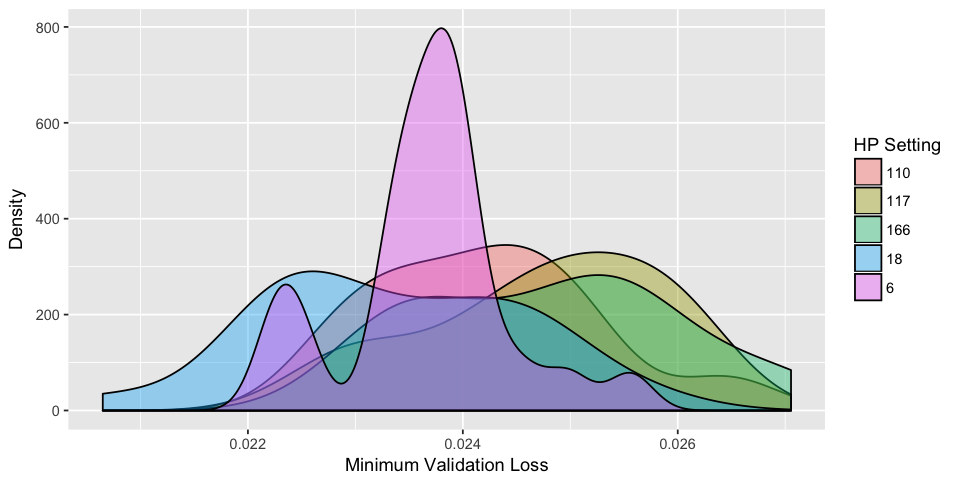

In [7]:
num.samples <- 5
# grp.idxs <- match(sort(sapply(psi.mnist, mean)), sapply(psi.mnist, mean))[1:num.samples]
mean.sample <- sample(sapply(psi.mnist, mean), 100)
grp.idxs <- match(sort(mean.sample), sapply(psi.mnist, mean))[1:num.samples]
# grp.idxs <- sample(1:num.groups, num.samples)
plot.df <- data.frame(MinValLoss=rep(NA, num.samples*25), Hyperparameters=rep(NA, num.samples*25))
for(i in 1:num.samples){
    plot.df$MinValLoss[((i-1)*25 + 1):((i)*25)] <- psi.mnist[[grp.idxs[i]]]
    plot.df$Hyperparameters[((i-1)*25 + 1):((i)*25)] <- paste(grp.idxs[i], sep="")
}
p <- ggplot(plot.df, aes(x=MinValLoss, fill=Hyperparameters))
p <- p + geom_density(alpha=0.4)
p <- p + labs(fill = "HP Setting", x="Minimum Validation Loss", y="Density")
p

In [763]:
ggsave("figures/MNIST-density.pdf", plot=p, width=8, height=4)

In [9]:
N <- 50
n.rows <- 4
mnist.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(mnist.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(mnist.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000


rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,4] <- unlist(rval)

mnist.results <- round(mnist.results,2)
mnist.results[4,] <- as.character(mnist.results[4,])
mnist.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.55,0.99,1,0.98
$\bar{|\mathcal{H}_0|}$,1,2.87,2.06,2.23
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,0.99,0.96,0.98,0.97
Avg Evaluations,50,250,500,172.68


In [632]:
print(xtable(mnist.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Tue Jan 22 18:54:54 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.54 & 0.99 & 1 & 0.98 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 2.89 & 2.08 & 2.16 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.99 & 0.96 & 0.98 & 0.98 \\ 
  Avg Evaluations & 50 & 250 & 500 & 171.59 \\ 
   \hline
\end{tabular}
\end{table}


In [10]:
N <- 100
n.rows <- 4
mnist.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(mnist.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(mnist.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000


rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,4] <- unlist(rval)

mnist.results <- round(mnist.results,2)
mnist.results[4,] <- as.character(mnist.results[4,])
mnist.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.41,0.99,1,0.97
$\bar{|\mathcal{H}_0|}$,1,4.2,2.97,3.15
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,0.99,0.97,0.98,0.98
Avg Evaluations,100,500,1000,334.75


In [11]:
print(xtable(mnist.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 13:56:08 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.41 & 0.99 & 1 & 0.97 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 4.2 & 2.97 & 3.15 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.99 & 0.97 & 0.98 & 0.98 \\ 
  Avg Evaluations & 100 & 500 & 1000 & 334.75 \\ 
   \hline
\end{tabular}
\end{table}


In [12]:
N <- 150
n.rows <- 4
mnist.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(mnist.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(mnist.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000


rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.mnist, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
mnist.results[,4] <- unlist(rval)

mnist.results <- round(mnist.results,2)
mnist.results[4,] <- as.character(mnist.results[4,])
mnist.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.37,0.99,1,0.97
$\bar{|\mathcal{H}_0|}$,1,5.88,4.25,4.22
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,1,0.97,0.98,0.98
Avg Evaluations,150,750,1500,496.55


In [13]:
print(xtable(mnist.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 13:56:33 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.37 & 0.99 & 1 & 0.97 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 5.88 & 4.25 & 4.22 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 1 & 0.97 & 0.98 & 0.98 \\ 
  Avg Evaluations & 150 & 750 & 1500 & 496.55 \\ 
   \hline
\end{tabular}
\end{table}


# Average Expected Difference

In [14]:
diff <- EvalComparisonDiff(psi.mnist, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = T)

In [15]:
round(mean(abs(diff)), 5)

[1] 0.00036

In [16]:
diff <- EvalComparisonDiff(psi.mnist, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = F)

In [17]:
round(mean(abs(diff)), 5)

[1] 8e-05

In [18]:
diff <- EvalComparisonDiff(psi.mnist, n.lambda=c(1), alpha=0.05, num.runs=1000, N=172, post.opt.runs=25)

In [19]:
round(mean(abs(diff)), 5)

[1] 0.00067

# IMDB

In [20]:
completed <- read.csv("./imdblstm//imdb_results.csv", header = T)
test.acc <- read.csv("./imdblstm//imdb_results_test.csv", header = T)


dropout_embedding.unique <- unique(completed$dropout_embedding)
num.distinct.values <- length(dropout_embedding.unique)
psi.imdb <- list()
psi.imdb.test <- list()
group.idx <- 1
psi.idx <- 1
for (group.idx in 1:num.distinct.values){
    this.df <- subset(completed, dropout_embedding == dropout_embedding.unique[group.idx])
    this.test.df <- subset(test.acc, dropout_embedding == dropout_embedding.unique[group.idx])
    if (length(this.df$Objective) == 25){
        psi.imdb[[psi.idx]] = 1.-this.df$Objective
        psi.imdb.test[[psi.idx]] = 1.-this.test.df$test_acc
        psi.idx <- psi.idx + 1
    } else {
        print(paste("Skipping", group.idx, "with number of repetitions", length(this.df$Objective)))
    }
}

num.groups <- length(psi.imdb)

[1] "Skipping 55 with number of repetitions 22"
[1] "Skipping 82 with number of repetitions 3"
[1] "Skipping 135 with number of repetitions 1"
[1] "Skipping 159 with number of repetitions 24"
[1] "Skipping 160 with number of repetitions 1"


In [21]:
num.groups

[1] 155

In [22]:
mean.psi <- unlist(lapply(psi.imdb, mean))
lambda.star <- which.min(mean.psi)

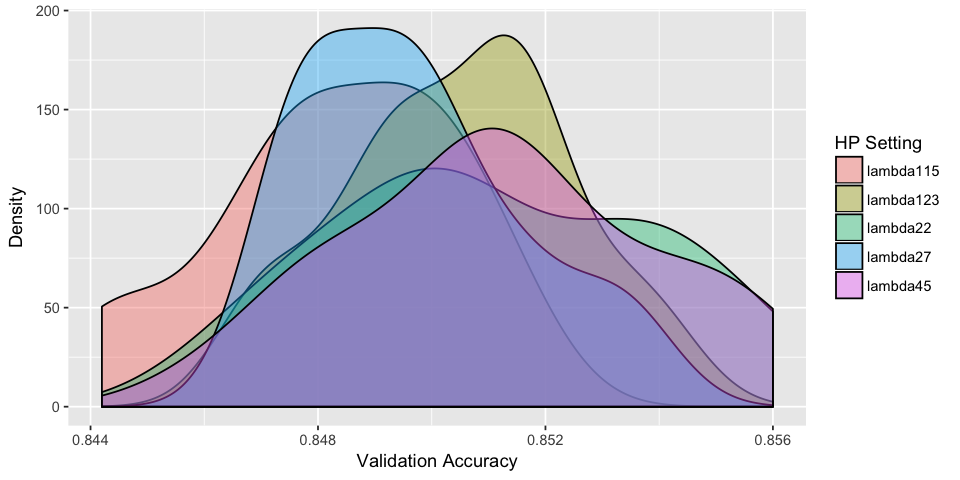

In [765]:
num.samples <- 5
# grp.idxs <- match(sort(sapply(psi.mnist, mean)), sapply(psi.mnist, mean))[1:num.samples]
mean.sample <- sample(sapply(psi.imdb, mean), 100)
grp.idxs <- match(sort(mean.sample), sapply(psi.imdb, mean))[1:num.samples]
plot.df <- data.frame(MinValLoss=rep(NA, num.samples*25), Hyperparameters=rep(NA, num.samples*25))
for(i in 1:num.samples){
    plot.df$MinValLoss[((i-1)*25 + 1):((i)*25)] <- 1.-psi.imdb[[grp.idxs[i]]]
    plot.df$Hyperparameters[((i-1)*25 + 1):((i)*25)] <- paste("lambda", grp.idxs[i], sep="")
}
p <- ggplot(plot.df, aes(x=MinValLoss, fill=Hyperparameters))
p <- p + geom_density(alpha=0.4)
p <- p + labs(fill = "HP Setting", x="Validation Accuracy", y="Density")
p

In [766]:
ggsave("figures/IMDB-density.pdf", plot=p, width=8, height=4)

In [25]:
N <- 50
n.rows <- 4
imdb.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(imdb.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(imdb.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,4] <- unlist(rval)

imdb.results <- round(imdb.results,2)
imdb.results[4,] <- as.character(imdb.results[4,])
imdb.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.52,0.99,1,0.98
$\bar{|\mathcal{H}_0|}$,1,3.28,2.43,2.38
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,0.99,0.95,0.97,0.97
Avg Evaluations,50,250,500,177.51


In [26]:
print(xtable(imdb.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 14:11:00 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.52 & 0.99 & 1 & 0.98 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 3.28 & 2.43 & 2.38 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.99 & 0.95 & 0.97 & 0.97 \\ 
  Avg Evaluations & 50 & 250 & 500 & 177.51 \\ 
   \hline
\end{tabular}
\end{table}


In [27]:
N <- 100
n.rows <- 4
imdb.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(imdb.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(imdb.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,4] <- unlist(rval)

imdb.results <- round(imdb.results,2)
imdb.results[4,] <- as.character(imdb.results[4,])
imdb.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.37,0.97,0.99,0.97
$\bar{|\mathcal{H}_0|}$,1,5.26,3.78,3.42
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,0.99,0.96,0.97,0.98
Avg Evaluations,100,500,1000,344.04


In [28]:
print(xtable(imdb.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 14:12:09 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.37 & 0.97 & 0.99 & 0.97 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 5.26 & 3.78 & 3.42 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.99 & 0.96 & 0.97 & 0.98 \\ 
  Avg Evaluations & 100 & 500 & 1000 & 344.04 \\ 
   \hline
\end{tabular}
\end{table}


In [29]:
N <- 150
n.rows <- 4
imdb.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(imdb.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(imdb.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
imdb.results[,4] <- unlist(rval)

imdb.results <- round(imdb.results,2)
imdb.results[4,] <- as.character(imdb.results[4,])
imdb.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.35,0.99,1,0.98
$\bar{|\mathcal{H}_0|}$,1,7.48,5.48,4.76
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,1,0.96,0.97,0.97
Avg Evaluations,150,750,1500,508.68


In [30]:
print(xtable(imdb.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 14:13:02 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.35 & 0.99 & 1 & 0.98 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 7.48 & 5.48 & 4.76 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 1 & 0.96 & 0.97 & 0.97 \\ 
  Avg Evaluations & 150 & 750 & 1500 & 508.68 \\ 
   \hline
\end{tabular}
\end{table}


# Average Expected Difference

In [31]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = T)

In [32]:
round(mean(abs(diff)), 5)

[1] 0.00136

In [33]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = F)

In [35]:
round(mean(abs(diff)), 5)

[1] 0.00018

In [36]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=1000, N=155, post.opt.runs=25)

In [37]:
round(mean(abs(diff)), 5)

[1] 0.00096

In [38]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = T, psi.test=psi.imdb.test)

In [39]:
round(mean(abs(diff)), 5)

[1] 0.00255

In [40]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=45, post.opt.runs=25, sample.lambda = F, psi.test=psi.imdb.test)

In [42]:
round(mean(abs(diff)), 5)

[1] 0.00095

In [43]:
diff <- EvalComparisonDiff(psi.imdb, n.lambda=c(1), alpha=0.05, num.runs=1000, N=155, post.opt.runs=25, psi.test=psi.imdb.test)

In [44]:
round(mean(abs(diff)), 5)

[1] 0.00235

# Boston

In [51]:
results <- read.csv("./bostongbrt/boston_results.csv", header = T)
completed <- subset(results, Status == 'COMPLETED')
completed <- completed[order(completed$Trial.ID),]

subsample.unique <- unique(completed$subsample)
num.groups <- length(subsample.unique)

psi.boston <- list()
for(i in 1:num.groups){
    this.df <- subset(completed, subsample == subsample.unique[i])
    psi.boston[[i]] <- this.df$Objective
}
lambda.star <- which.min(unlist(lapply(psi.boston, mean)))

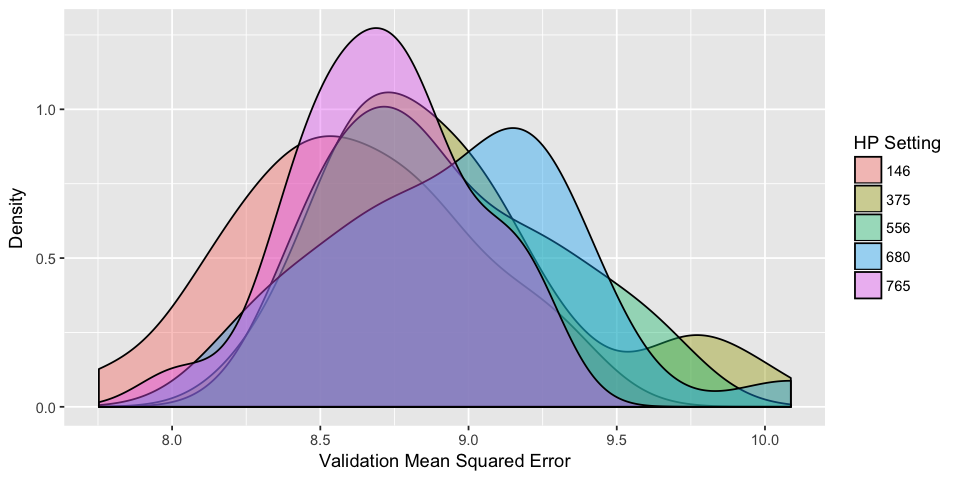

In [53]:
num.samples <- 5
mean.sample <- sample(sapply(psi.boston, mean), 100)
grp.idxs <- match(sort(mean.sample), sapply(psi.boston, mean))[1:num.samples]
plot.df <- data.frame(MinValLoss=rep(NA, num.samples*25), Hyperparameters=rep(NA, num.samples*25))
for(i in 1:num.samples){
    plot.df$MinValLoss[((i-1)*25 + 1):((i)*25)] <- psi.boston[[grp.idxs[i]]]
    plot.df$Hyperparameters[((i-1)*25 + 1):((i)*25)] <- paste("", grp.idxs[i], sep="")
#     plot.df$Group[((i-1)*25 + 1):((i)*25)] <- TeX(paste("$\\lambda_", grp.idxs[i], "$", sep=""))
}
p <- ggplot(plot.df, aes(x=MinValLoss, fill=Hyperparameters))
p <- p + geom_density(alpha=0.4)
p <- p + labs(fill = "HP Setting", x="Validation Mean Squared Error", y="Density")
p

In [775]:
ggsave("figures/Boston-density.pdf", plot=p, width=8, height=4)

In [54]:
N <- 50

n.rows <- 4
boston.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(boston.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(boston.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,4] <- unlist(rval)

boston.results <- round(boston.results,2)
boston.results[4,] <- as.character(boston.results[4,])
boston.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.06,0.99,1,0.96
$\bar{|\mathcal{H}_0|}$,1,27.38,19.5,18.73
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,0.98,0.46,0.62,0.64
Avg Evaluations,50,250,500,317.95


In [55]:
print(xtable(boston.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 14:23:57 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.06 & 0.99 & 1 & 0.96 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 27.38 & 19.5 & 18.73 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.98 & 0.46 & 0.62 & 0.64 \\ 
  Avg Evaluations & 50 & 250 & 500 & 317.95 \\ 
   \hline
\end{tabular}
\end{table}


In [56]:
N <- 100

n.rows <- 4
boston.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(boston.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(boston.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,4] <- unlist(rval)

boston.results <- round(boston.results,2)
boston.results[4,] <- as.character(boston.results[4,])
boston.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.04,0.99,1,0.96
$\bar{|\mathcal{H}_0|}$,1,53.73,35.24,34.05
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,0.99,0.47,0.65,0.67
Avg Evaluations,100,500,1000,624.91


In [57]:
print(xtable(boston.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 14:24:13 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.04 & 0.99 & 1 & 0.96 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 53.73 & 35.24 & 34.05 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.99 & 0.47 & 0.65 & 0.67 \\ 
  Avg Evaluations & 100 & 500 & 1000 & 624.91 \\ 
   \hline
\end{tabular}
\end{table}


In [58]:
N <- 150

n.rows <- 4
boston.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(boston.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(boston.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
boston.results[,4] <- unlist(rval)

boston.results <- round(boston.results,2)
boston.results[4,] <- as.character(boston.results[4,])
boston.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.02,0.99,1,0.97
$\bar{|\mathcal{H}_0|}$,1,79.65,51.5,50.58
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,0.99,0.47,0.66,0.67
Avg Evaluations,150,750,1500,934.28


In [59]:
print(xtable(boston.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 14:24:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.02 & 0.99 & 1 & 0.97 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 79.65 & 51.5 & 50.58 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.99 & 0.47 & 0.66 & 0.67 \\ 
  Avg Evaluations & 150 & 750 & 1500 & 934.28 \\ 
   \hline
\end{tabular}
\end{table}


# Average Expected Difference

In [60]:
diff <- EvalComparisonDiff(psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = T)

In [61]:
round(mean(abs(diff)), 5)

[1] 0.28924

In [62]:
diff <- EvalComparisonDiff(psi.boston, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = F)

In [63]:
round(mean(abs(diff)), 5)

[1] 0.12015

In [64]:
diff <- EvalComparisonDiff(psi.boston, n.lambda=c(1), alpha=0.05, num.runs=1000, N=320, post.opt.runs=25)

In [65]:
round(mean(abs(diff)), 5)

[1] 0.31287

# Cartpole

In [67]:
completed <- read.csv("./cartpole/cartpole_results.csv", header = T)
completed <- completed[order(completed$Trial.ID),]

gamma.unique <- unique(completed$gamma)
num.groups <- length(gamma.unique)

psi.cartpole <- list()
for(i in 1:num.groups){
    this.df <- subset(completed, gamma == gamma.unique[i])
    psi.cartpole[[i]] <- 1-this.df$auc
}
lambda.star <- which.min(unlist(lapply(psi.cartpole, mean)))

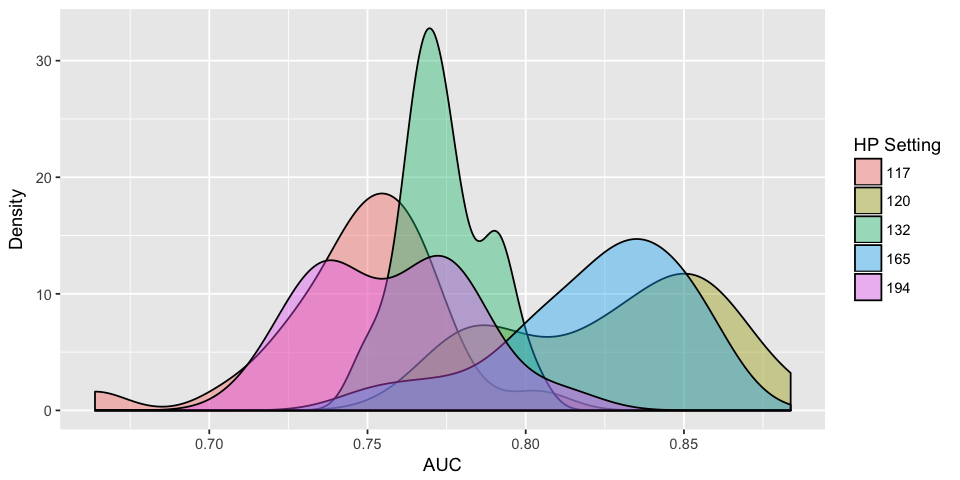

In [69]:
num.samples <- 5
grp.idxs <- match(sort(sapply(psi.cartpole, mean)), sapply(psi.cartpole, mean))[1:num.samples]
# mean.sample <- sample(sapply(psi.cartpole, mean), 100)
# grp.idxs <- match(sort(mean.sample), sapply(psi.cartpole, mean))[1:num.samples]
plot.df <- data.frame(MinValLoss=rep(NA, num.samples*25), Hyperparameters=rep(NA, num.samples*25))
for(i in 1:num.samples){
    plot.df$MinValLoss[((i-1)*25 + 1):((i)*25)] <- 1.-psi.cartpole[[grp.idxs[i]]]
    plot.df$Hyperparameters[((i-1)*25 + 1):((i)*25)] <- paste("", grp.idxs[i], sep="")
}
p <- ggplot(plot.df, aes(x=MinValLoss, fill=Hyperparameters))
p <- p + geom_density(alpha=0.4)
p <- p + labs(fill = "HP Setting", x="AUC", y="Density")
p

In [735]:
ggsave("figures/Cartpole-density.pdf", plot=p, width=8, height=4)

In [70]:
N <- 50

n.rows <- 4
cartpole.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(cartpole.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(cartpole.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,4] <- unlist(rval)

cartpole.results <- round(cartpole.results,2)
cartpole.results[4,] <- as.character(cartpole.results[4,])
cartpole.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.82,0.99,1,0.98
$\bar{|\mathcal{H}_0|}$,1,1.41,1.29,1.26
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,1,0.99,0.99,0.99
Avg Evaluations,50,250,500,159.07


In [71]:
print(xtable(cartpole.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 14:29:05 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.82 & 0.99 & 1 & 0.98 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 1.41 & 1.29 & 1.26 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 1 & 0.99 & 0.99 & 0.99 \\ 
  Avg Evaluations & 50 & 250 & 500 & 159.07 \\ 
   \hline
\end{tabular}
\end{table}


In [72]:
N <- 100

n.rows <- 4
cartpole.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(cartpole.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(cartpole.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,4] <- unlist(rval)

cartpole.results <- round(cartpole.results,2)
cartpole.results[4,] <- as.character(cartpole.results[4,])
cartpole.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.7,0.99,1,0.99
$\bar{|\mathcal{H}_0|}$,1,1.67,1.49,1.43
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,1,0.99,1,1
Avg Evaluations,100,500,1000,311.49


In [73]:
print(xtable(cartpole.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 14:29:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.7 & 0.99 & 1 & 0.99 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 1.67 & 1.49 & 1.43 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 1 & 0.99 & 1 & 1 \\ 
  Avg Evaluations & 100 & 500 & 1000 & 311.49 \\ 
   \hline
\end{tabular}
\end{table}


In [74]:
N <- 150

n.rows <- 4
cartpole.results <- data.frame('1'=rep(NA, n.rows),
                            '5'=rep(NA, n.rows),
                            '10'=rep(NA, n.rows),
                            '3,6,9'=rep(NA, n.rows))
rownames(cartpole.results) <- c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                             '$\\bar{|\\mathcal{H}_0|}$',
                             '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                             'Avg Evaluations')
colnames(cartpole.results) <- c('1', '5', '10', '(3,6,9)')
num.runs <- 1000

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(1), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,1] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(5), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,2] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(10), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,3] <- unlist(rval)

rval <- EvalMetrics(psi=psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=num.runs, N=N)
cartpole.results[,4] <- unlist(rval)

cartpole.results <- round(cartpole.results,2)
cartpole.results[4,] <- as.character(cartpole.results[4,])
cartpole.results

,1,5,10,"(3,6,9)"
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$,0.63,0.99,1,0.97
$\bar{|\mathcal{H}_0|}$,1,1.77,1.61,1.56
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$,1,0.99,1,1
Avg Evaluations,150,750,1500,463.28


In [75]:
print(xtable(cartpole.results), type="latex", sanitize.text.function = function(x){x})

% latex table generated in R 3.4.2 by xtable 1.8-3 package
% Wed Jan 23 14:29:43 2019
\begin{table}[ht]
\centering
\begin{tabular}{rllll}
  \hline
 & 1 & 5 & 10 & (3,6,9) \\ 
  \hline
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.63 & 0.99 & 1 & 0.97 \\ 
  $\bar{|\mathcal{H}_0|}$ & 1 & 1.77 & 1.61 & 1.56 \\ 
  $\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 1 & 0.99 & 1 & 1 \\ 
  Avg Evaluations & 150 & 750 & 1500 & 463.28 \\ 
   \hline
\end{tabular}
\end{table}


# Average Expected Difference

In [76]:
diff <- EvalComparisonDiff(psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = T)

In [77]:
round(mean(abs(diff)), 5)

[1] 0.00323

In [78]:
diff <- EvalComparisonDiff(psi.cartpole, n.lambda=c(3,6,9), alpha=0.05, num.runs=1000, N=50, post.opt.runs=25, sample.lambda = F)

In [79]:
round(mean(abs(diff)), 5)

[1] 0.00098

In [80]:
diff <- EvalComparisonDiff(psi.cartpole, n.lambda=c(1), alpha=0.05, num.runs=1000, N=159, post.opt.runs=25)

In [81]:
round(mean(abs(diff)), 5)

[1] 0.01504

# CIFAR10 Grid Search

In [29]:
results <- read.csv("./cifar10resnet/cifar10_resnet.csv", header = T)
completed <- results[results$Status=="COMPLETED",]
completed <- completed[order(completed$Trial.ID),]

lr.unique <- unique(completed$lr)
num.groups <- length(lr.unique)
lr <- rep(NA, 10)

psi.cifar <- list()
for(i in 1:num.groups){
    this.df <- subset(completed, lr == lr.unique[i])
    psi.cifar[[i]] <- 1-this.df$Objective
    lr[i] <- lr.unique[i]
}
lambda.star <- which.min(unlist(lapply(psi.cifar, mean)))

In [31]:
psi.cifar <- psi.cifar[1:5]
num.groups <- length(psi.cifar)
lr <- lr[1:5]

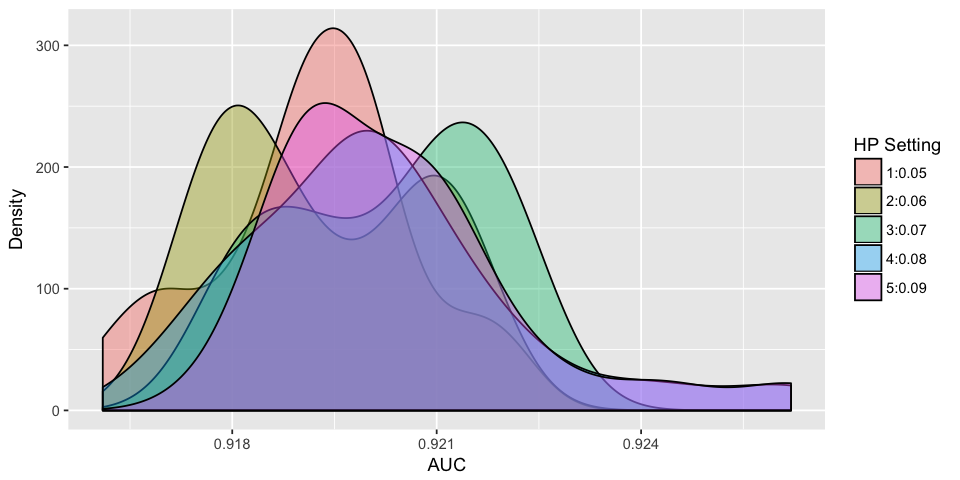

In [32]:
num.samples <- 5
grp.idxs <- 1:num.groups
plot.df <- data.frame(ValAccuracy=rep(NA, num.samples*25), Hyperparameters=rep(NA, num.samples*25))
for(i in 1:num.samples){
    plot.df$ValAccuracy[((i-1)*25 + 1):((i)*25)] <- 1.-psi.cifar[[grp.idxs[i]]]
    plot.df$Hyperparameters[((i-1)*25 + 1):((i)*25)] <- paste("", grp.idxs[i],":", lr.unique[i], sep="")
}
p <- ggplot(plot.df, aes(x=ValAccuracy, fill=Hyperparameters))
p <- p + geom_density(alpha=0.4)
p <- p + labs(fill = "HP Setting", x="AUC", y="Density")
p